In [113]:
import tensorflow.compat.v2 as tfc
import tensorflow as tf

import pathlib
import numpy as np
import pandas as pd
import IPython.display as display

from functools import partial
import matplotlib.pyplot as plt

TESTED_ATTR = 'Eyeglasses'
IMAGE_SIZE = [218, 178]
BATCH_SIZE = 64
AUTOTUNE = tf.data.experimental.AUTOTUNE
DATASET_SIZE = 202599
TRAIN_SIZE = int(0.7 * DATASET_SIZE)
VAL_SIZE = int(0.15 * DATASET_SIZE)
TEST_SIZE = int(0.15 * DATASET_SIZE)

tf.compat.v1.enable_eager_execution()
tf.enable_eager_execution()

In [114]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print("Device:", tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print("Number of replicas:", strategy.num_replicas_in_sync)

Number of replicas: 1


In [115]:
def _decode_image(raw_img):
    img = tf.image.decode_png(raw_img, channels=3)
    img = tf.cast(img, tf.float32)
    img = tf.reshape(img, [*IMAGE_SIZE, 3])
    return img

In [116]:
def _parse_images_function(example, labels, attribute_name):
    image_feature_description = {
        'height': tf.io.FixedLenFeature([], tf.int64),
        'width': tf.io.FixedLenFeature([], tf.int64),
        'depth': tf.io.FixedLenFeature([], tf.int64),
        'raw': tf.io.FixedLenFeature([], tf.string),
    }
    
    for col in labels:
        if col == 'filename':
            image_feature_description[col] = tf.io.FixedLenFeature([], tf.string)
        else:
            image_feature_description[col] = tf.io.FixedLenFeature([], tf.int64)
    
    example = tf.io.parse_single_example(example, image_feature_description)
    img = _decode_image(example['raw'])
    lbl = example[attribute_name]
    
    return img, lbl

In [117]:
def _get_tensor_tuple(parsed_example, label):
    return (_decode_image(parsed_example['raw']), parsed_example[label].numpy())

In [118]:
def parse_dataset(dataset, labels):
    return dataset.map(partial(_parse_images_function, labels=labels, attribute_name=TESTED_ATTR))

In [119]:
def make_dataset(parsed_image_dataset):
    parsed_image_dataset = parse_dataset(raw_image_dataset, df.columns)
    parsed_image_dataset = parsed_image_dataset.shuffle(2048)
    parsed_image_dataset = parsed_image_dataset.prefetch(buffer_size=AUTOTUNE)
    parsed_image_dataset = parsed_image_dataset.batch(BATCH_SIZE)
    return parsed_image_dataset

In [126]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10, 10))
    for n in range(25):
        ax = plt.subplot(5, 5, n + 1)
        plt.imshow(image_batch[n] / 255.0)

        if label_batch[n].numpy():
            plt.title("GLASSES")
        else:
            plt.title("NO GLASSES")
        plt.axis("off")

In [121]:
def make_model():
    base_model = tf.keras.applications.Xception(
        input_shape=(*IMAGE_SIZE, 3), include_top=False, weights="imagenet"
    )

    base_model.trainable = False

    inputs = tf.keras.layers.Input([*IMAGE_SIZE, 3])
    x = tf.keras.applications.xception.preprocess_input(inputs)
    x = base_model(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(8, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.7)(x)
    outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
        loss="binary_crossentropy",
        metrics=[tf.keras.metrics.AUC(name="auc")],
    )

    return model

In [122]:
data_dir = pathlib.Path('../../datasets/celeba')
img_dir = pathlib.Path(str(data_dir) + '/img_align_celeba_png')
attr_dir = pathlib.Path(str(data_dir) + '/attr_celeba.csv')
dataset_file = 'images.tfrecords'

In [123]:
df = pd.read_csv(attr_dir)
df.replace(to_replace = -1, value = False, inplace = True)
df.replace(to_replace = 1, value = True, inplace = True)


full_dataset = tf.data.TFRecordDataset(dataset_file)

train_dataset = full_dataset.take(TRAIN_SIZE)
test_dataset = full_dataset.skip(TRAIN_SIZE)
val_dataset = test_dataset.skip(VAL_SIZE)
test_dataset = test_dataset.take(TEST_SIZE)

In [124]:
train_dataset = make_dataset(train_dataset)
test_dataset = make_dataset(test_dataset)
val_dataset = make_dataset(val_dataset)

<tf.Tensor: id=35435, shape=(64,), dtype=int64, numpy=
array([0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0])>

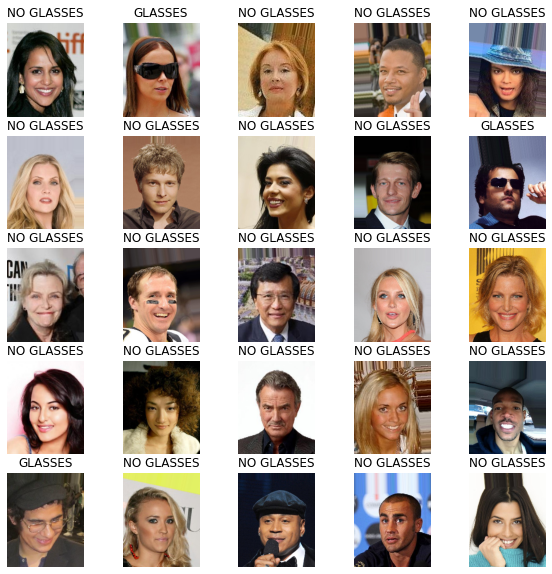

In [127]:
image_batch, label_batch = next(iter(train_dataset))
show_batch(image_batch, label_batch)
label_batch

In [131]:
initial_learning_rate = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=20, decay_rate=0.96, staircase=True
)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "glasses_model.h5", save_best_only=True, monitor='val_accuracy'
)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    patience=10, restore_best_weights=True
)

In [132]:
with strategy.scope():
    model = make_model()

In [133]:
history = model.fit(
    train_dataset,
    epochs=2,
    validation_data=val_dataset,
    callbacks=[checkpoint_cb, early_stopping_cb],
)

Epoch 1/2
     60/Unknown - 23s 376ms/step - loss: 0.4148 - auc: 0.6037WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.
     60/Unknown - 23s 376ms/step - loss: 0.4148 - auc: 0.6037

KeyboardInterrupt: 